- (M-N) in the end of markdown means it references M-N task
- 'P)' means 'Problem' and 'S)' means 'Solution for problem'

- This is practice for basic EDA
- Boosting, Ensembling is not used.
- Best RMSE score : 0.07635572239366556

# 1. Import library and load csv(DataSet)

In [2]:
!pip install --upgrade category_encoders
!pip install --upgrade encoders



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00a 0:00:01


















     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.7/609.7 kB 3.6 MB/s eta 0:00:00




In [11]:
!kaggle competitions download -c home-data-for-ml-course

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [18]:
train = pd.read_csv('/kaggle/input/housing-price/train.csv')
test = pd.read_csv('/kaggle/input/housing-price/test.csv')
submission = pd.read_csv('/kaggle/input/housing-price/sample_submission.csv')

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn models
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,  VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

# Regularization, Estimator
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.model_selection import cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import mean_squared_log_error # RMSLE
from sklearn.metrics import mean_squared_error # RMSE

# Boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Scaler, Encoder, Regulariation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import category_encoders as ce

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Preparation for EDA

Header's meaning
- SalesPrice : target value
-  Lot size(floor space) : '1stFlrSF+2stFlrSF(first+second floor square feet)'has low correlation

In [20]:
train.head(10).T

,0,1,2,3,4,5,6,7,8,9
Id,1,2,3,4,5,6,7,8,9,10
MSSubClass,60,20,60,70,60,50,20,60,50,190
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL
LotFrontage,65.0,80.0,68.0,60.0,84.0,85.0,75.0,NaN,51.0,50.0
LotArea,8450,9600,11250,9550,14260,14115,10084,10382,6120,7420
...,...,...,...,...,...,...,...,...,...,...
MoSold,2,5,9,2,12,10,8,11,4,1
YrSold,2008,2007,2008,2006,2008,2009,2007,2009,2008,2008
SaleType,WD,WD,WD,WD,WD,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal,Normal,Normal,Normal,Abnorml,Normal


Headers dtypes: float64(3), int64(35), object(43)
- Numeric, Object features are mixed, so dividing them is needed

In [7]:
# test doesn't have target('SalePrice') header
train.shape, test.shape

((1460, 81), (1459, 80))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 1460 entries, 0 to 1459

Data columns (total 81 columns):

 #   Column         Non-Null Count  Dtype  

---  ------         --------------  -----  

 0   Id             1460 non-null   int64  

 1   MSSubClass     1460 non-null   int64  

 2   MSZoning       1460 non-null   object 

 3   LotFrontage    1201 non-null   float64

 4   LotArea        1460 non-null   int64  

 5   Street         1460 non-null   object 

 6   Alley          91 non-null     object 

 7   LotShape       1460 non-null   object 

 8   LandContour    1460 non-null   object 

 9   Utilities      1460 non-null   object 

 10  LotConfig      1460 non-null   object 

 11  LandSlope      1460 non-null   object 

 12  Neighborhood   1460 non-null   object 

 13  Condition1     1460 non-null   object 

 14  Condition2     1460 non-null   object 

 15  BldgType       1460 non-null   object 

 16  HouseStyle     1460 non-null   object 

 17  OverallQual    1460 non-null  

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


- I thought watching headers have low 'max-min' would be meaningful
- Some features has low std(<1). Visualization would be needed
- Headers dtype : 'Numeric+Object'

**1. Because 'Id' is 'Index header', drop it**

In [10]:
train = train.drop(['Id'], axis=1)

**2. Create feature's list which Na's ratio is bigger than 0.4**

In [11]:
na_columns = [] # High Na ratio feature's list

for col in train.columns.tolist() :
  if train[col].isna().sum() > train.shape[0]*0.4 :
    print(col, train[col].isna().sum())
    na_columns.append(col)

Alley 1369

MasVnrType 872

FireplaceQu 690

PoolQC 1453

Fence 1179

MiscFeature 1406


- Those features have too many Na value, and it makes modeling hard -> drop
- 'MasVnrType', 'FireplaceQu' features are 0.5 Na ratio -> It might be needed for modeling

**3. Create Co-relation Matrix : focus on Target('SalePrice')**

In [12]:
num_cols = train.select_dtypes(exclude = ['object']).columns
object_cols = train.select_dtypes(include = ['object']).columns

In [13]:
# Corr : Numeric features & target('SalePrice')
# Extract features which has low(<0.05) co-relation
low_corr_num_cols = []

for i, n in enumerate(train[num_cols].corr().iloc[:, -1]) :
  if abs(n) < 0.05 :
    print(num_cols[i], n)
    low_corr_num_cols.append(num_cols[i])

BsmtFinSF2 -0.011378121450215146

LowQualFinSF -0.02560613000067955

BsmtHalfBath -0.01684415429735895

3SsnPorch 0.04458366533574838

MiscVal -0.021189579640303213

MoSold 0.046432245223819446

YrSold -0.028922585168736813


- Low co-relation features are extraced

# 3. Visualization

**1. Distribution of target('SalePrice')**

<Axes: xlabel='SalePrice', ylabel='Count'>

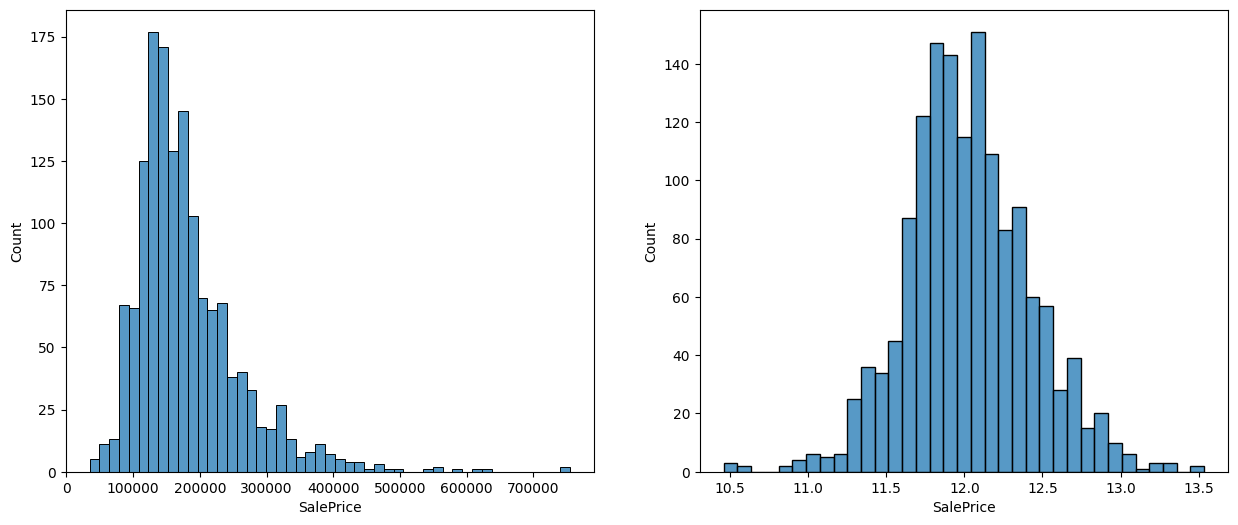

In [ ]:
figure, axes = plt.subplots(ncols=2, figsize=(15, 6))

sns.histplot(train['SalePrice'], ax=axes[0])
sns.histplot(np.log(train['SalePrice']), ax=axes[1])

- log(Target('SalePrice') value) is close to normal-distribution than 'Target value'
- log calculation would be needed for modeling

**2. Histplot을 통해 Numeric feature의 Distribution 파악. : target은 log연산**

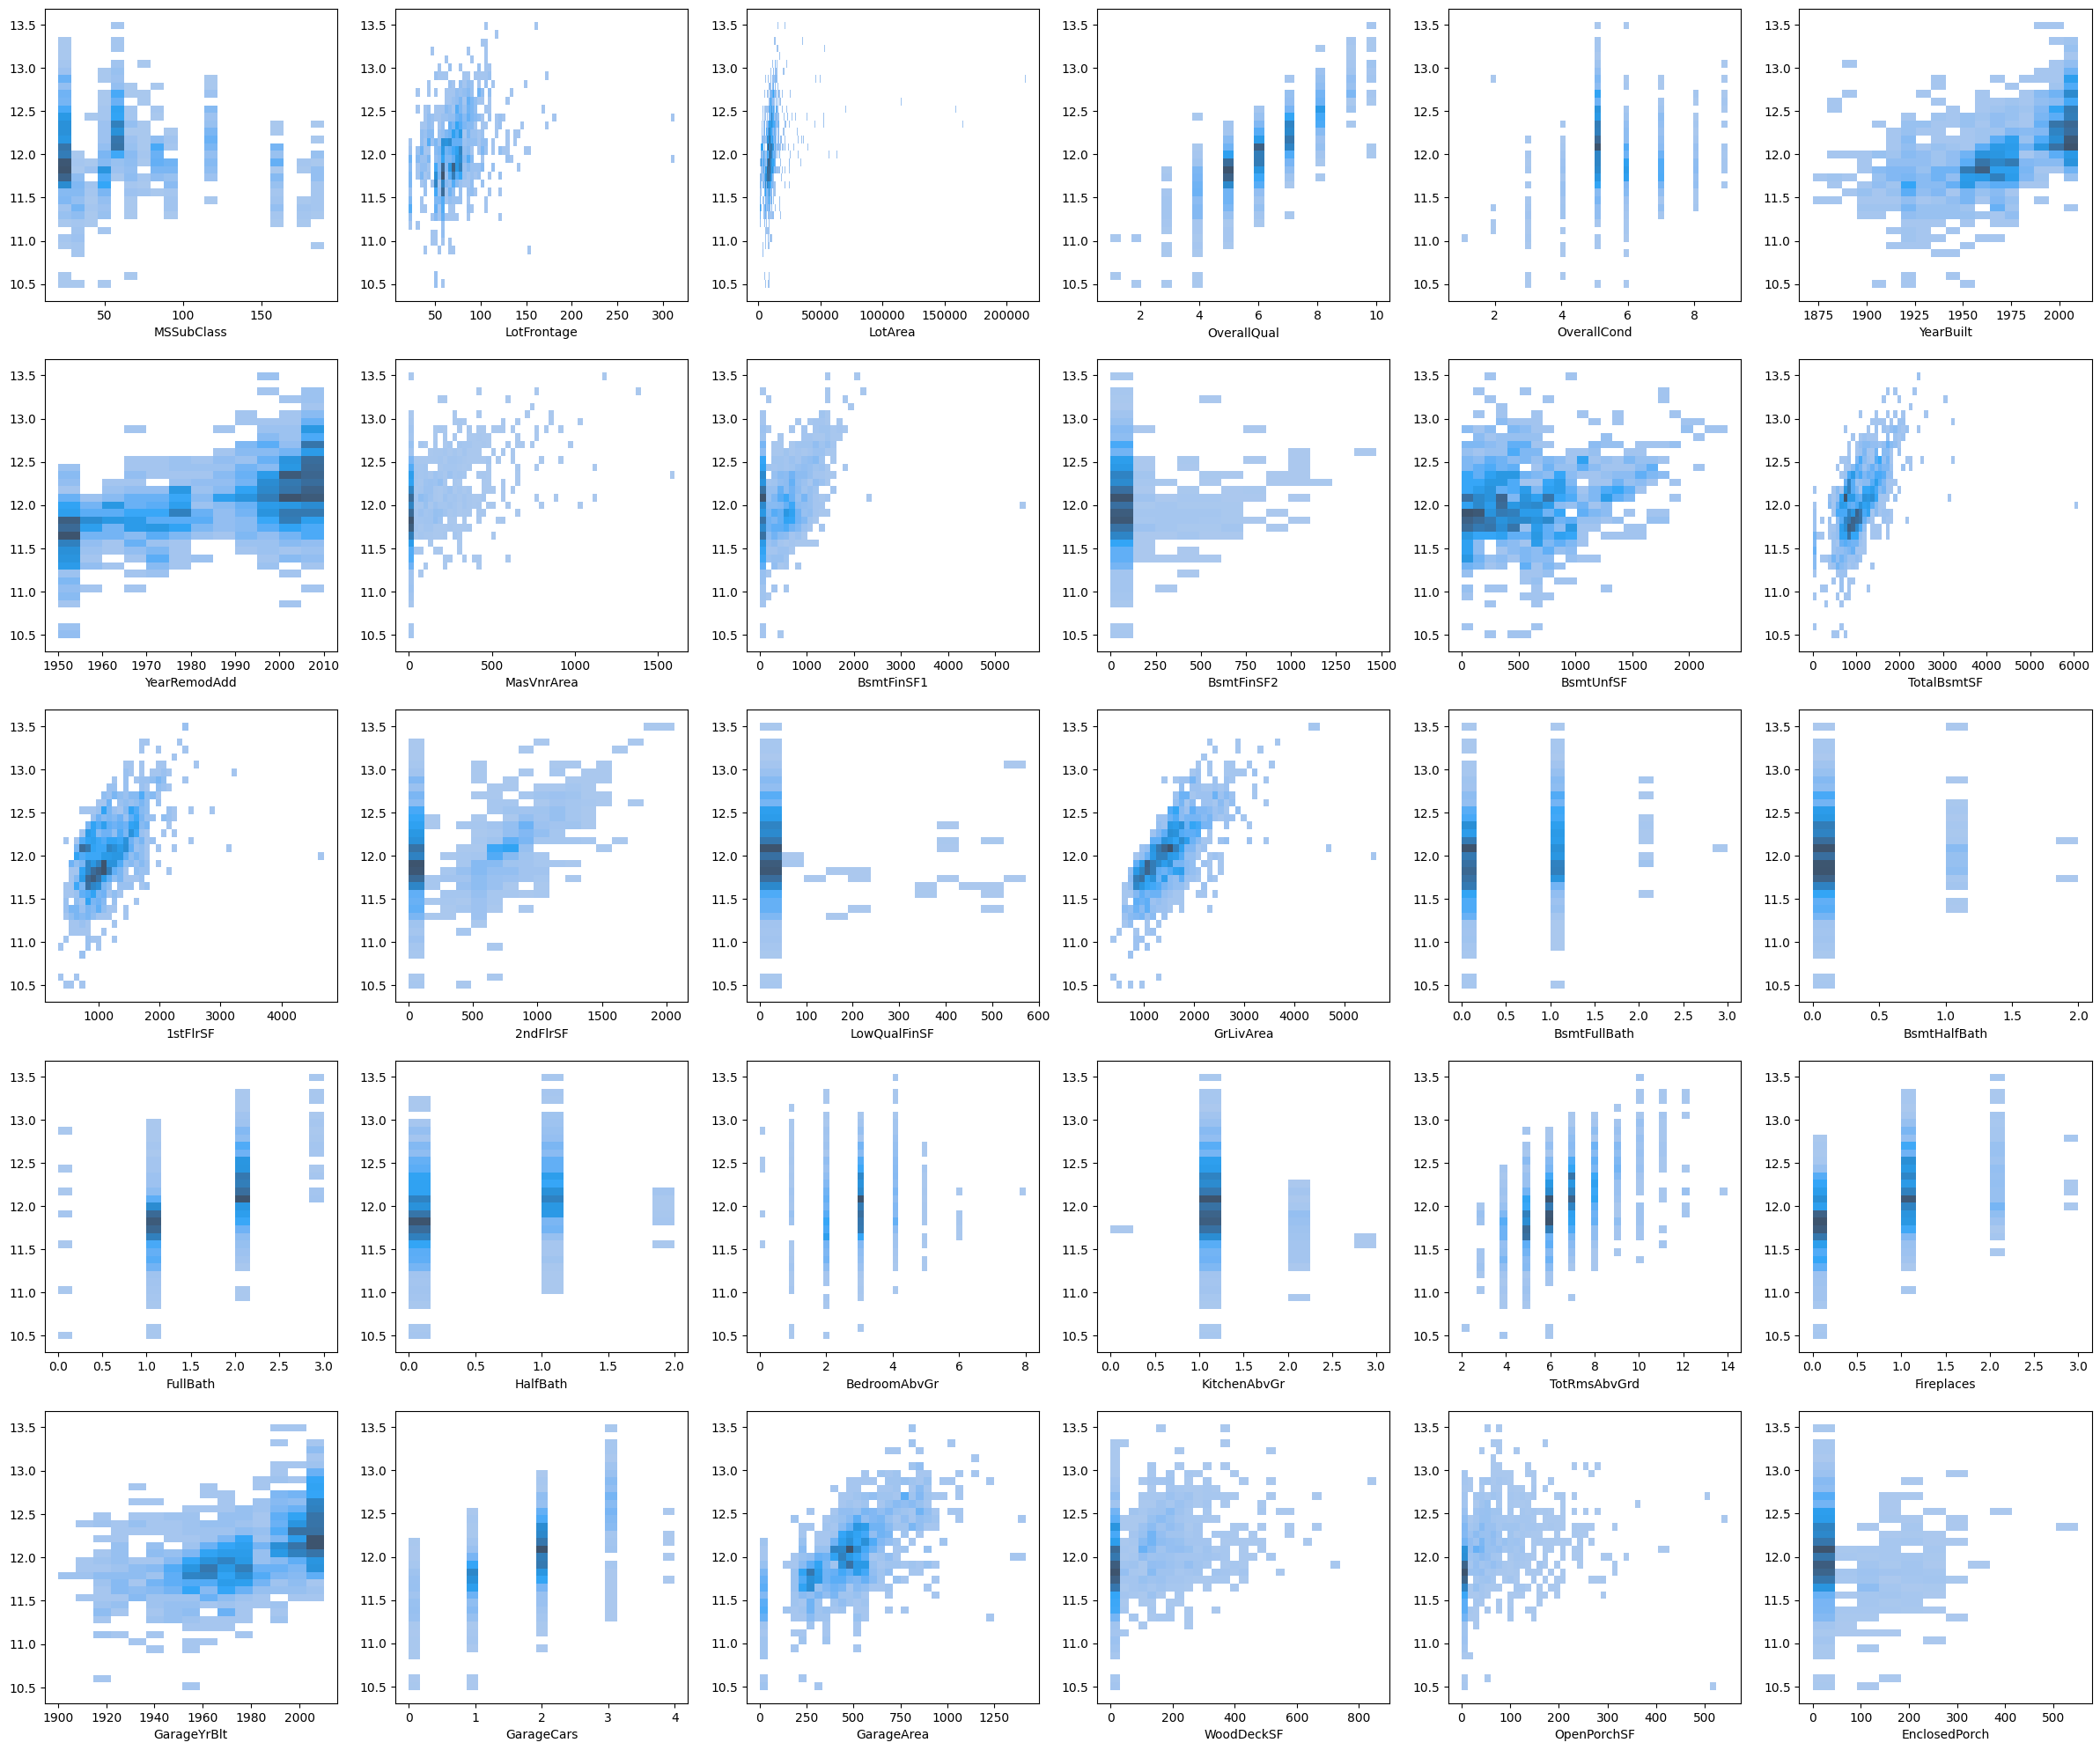

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, label='off', figsize=(30, 25))
n = 0

for i in range(5) :
  for j in range(6) :
    sns.histplot(x=num_cols[n], y=np.log(train['SalePrice']), data=train, ax=axes[i, j])
    axes[i, j].set_ylabel('')
    n += 1

- Uncontinus features are need to be re-visualized as boxplot
- Boxplot would find ouliers and statistic informations.

**3. Watch outlier using Boxplot : Dtype(Numeric & Object)**

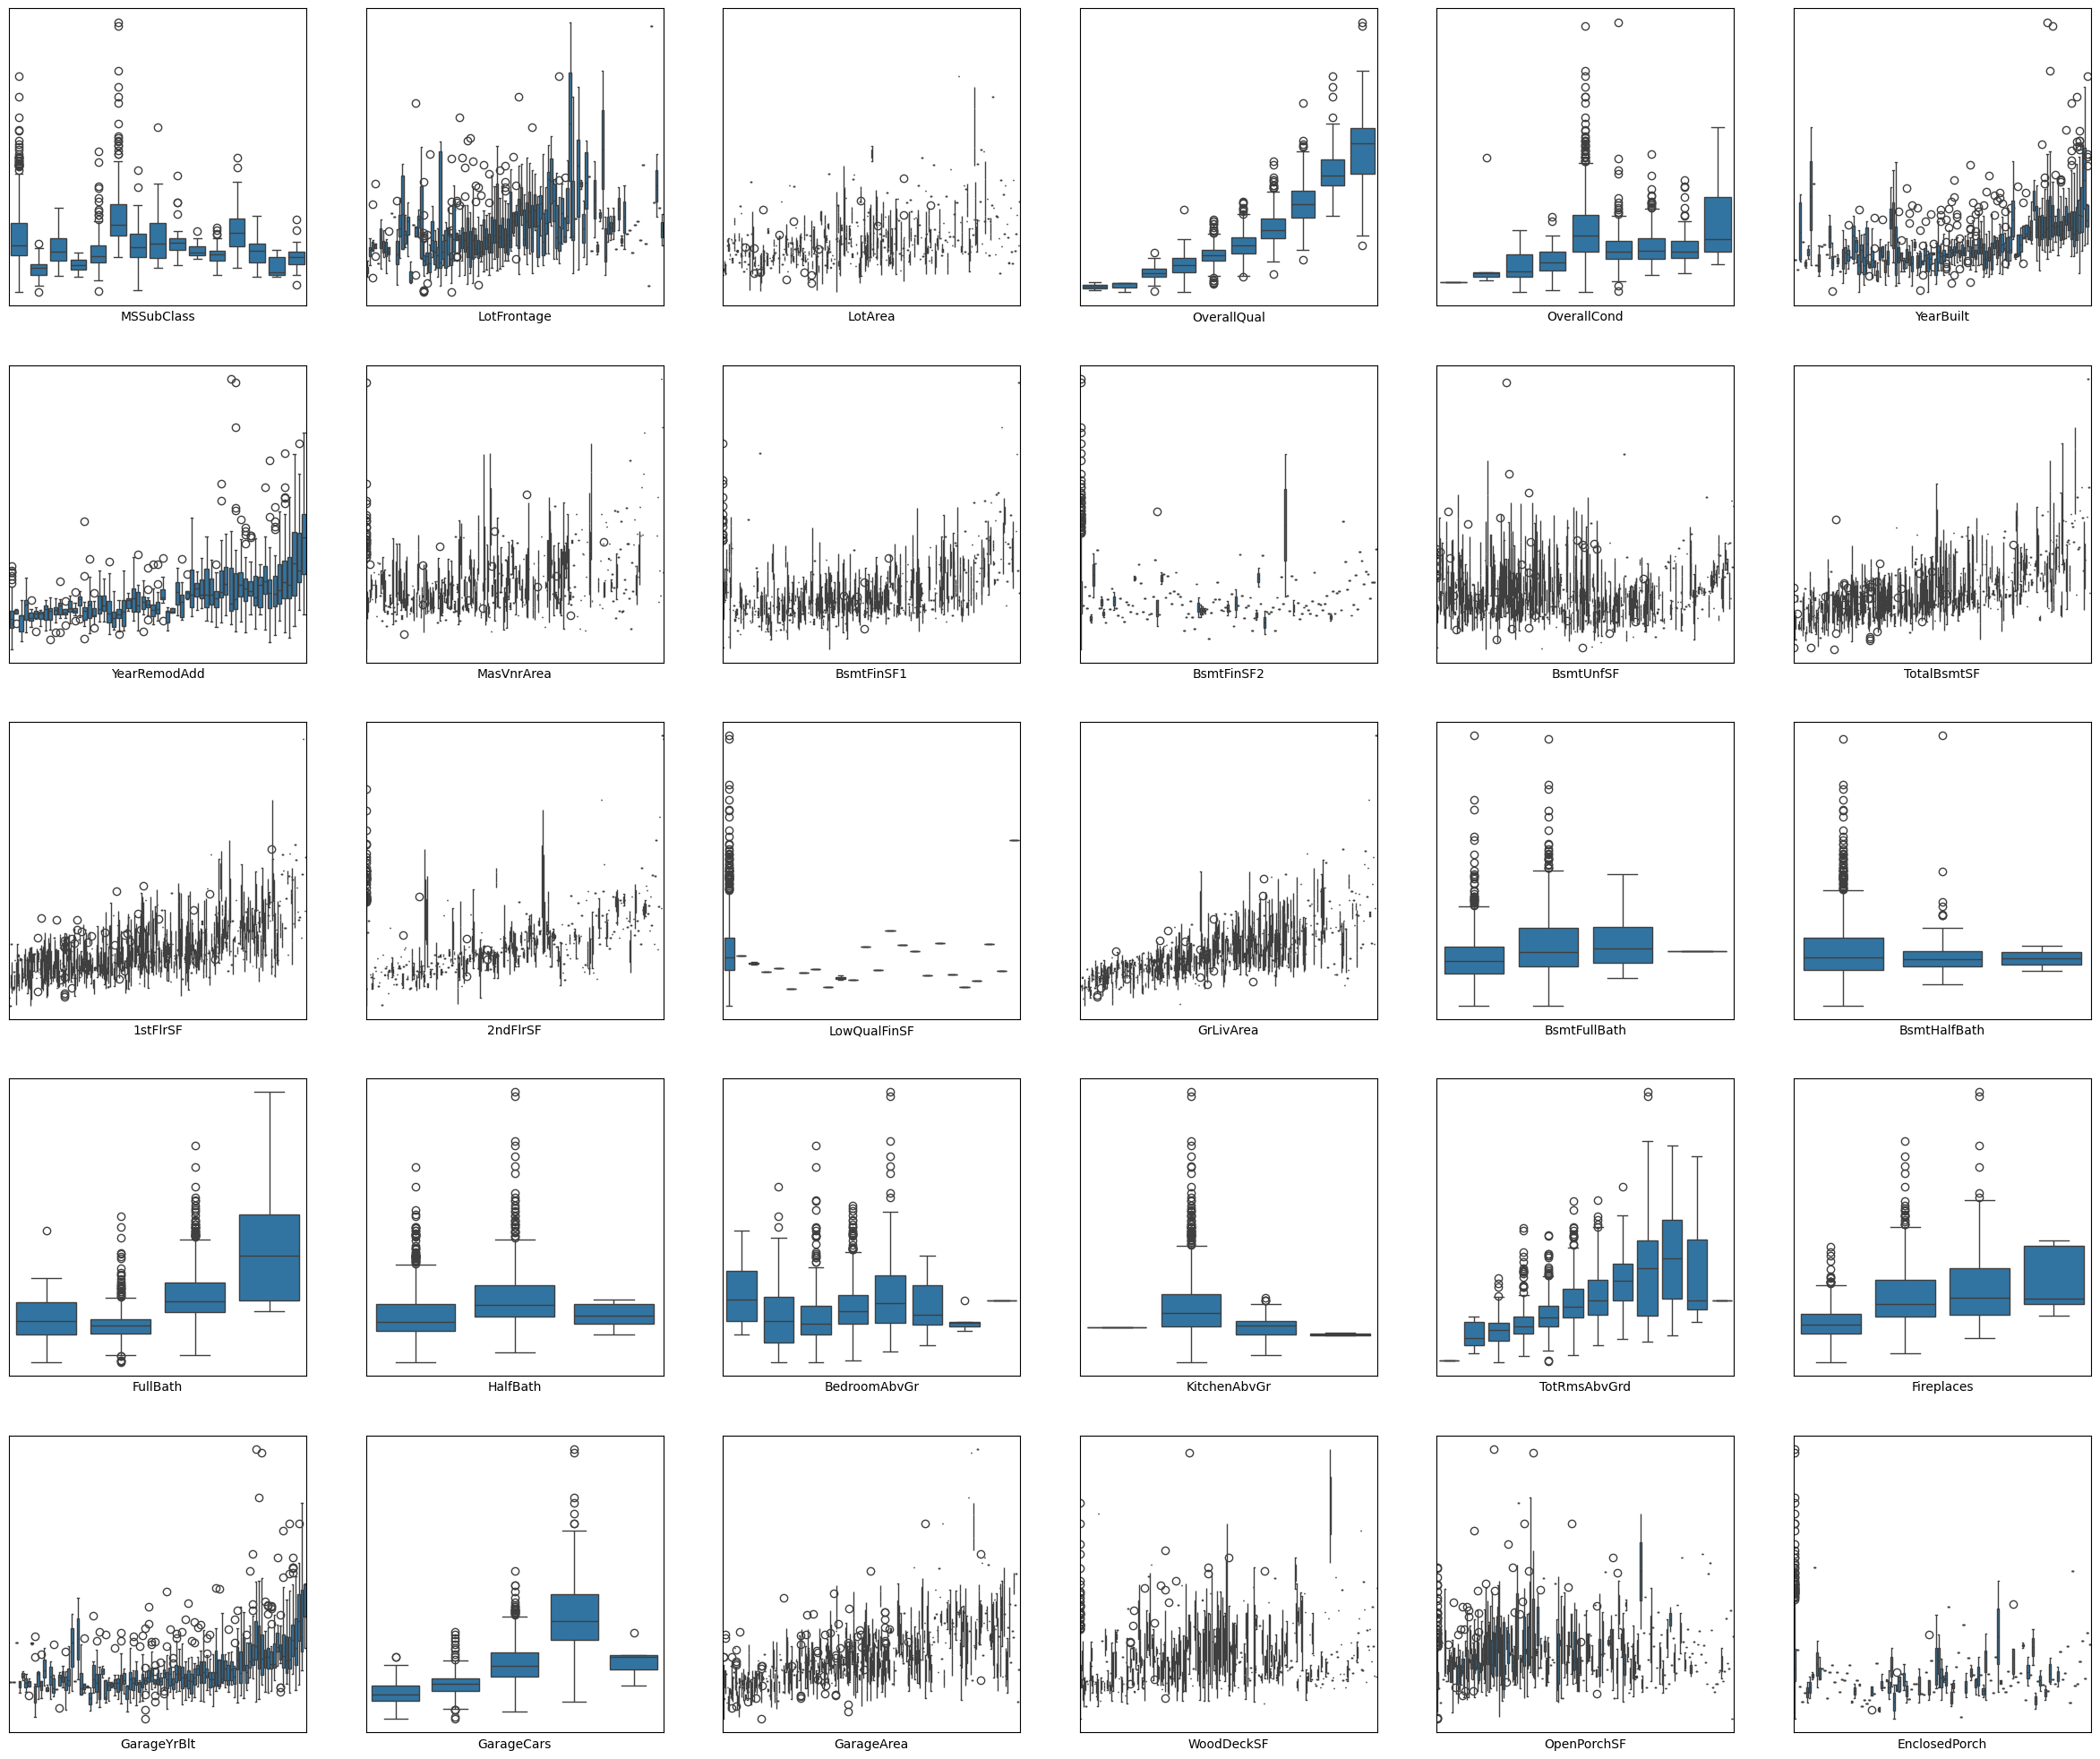

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, label='off', figsize=(30, 25))
n = 0

for i in range(5) :
  for j in range(6) :
    # Dtype(feature) = Numeric
    sns.boxplot(x=num_cols[n], y=train['SalePrice'], data=train, ax=axes[i, j])
    axes[i, j].set_ylabel('')
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    n += 1

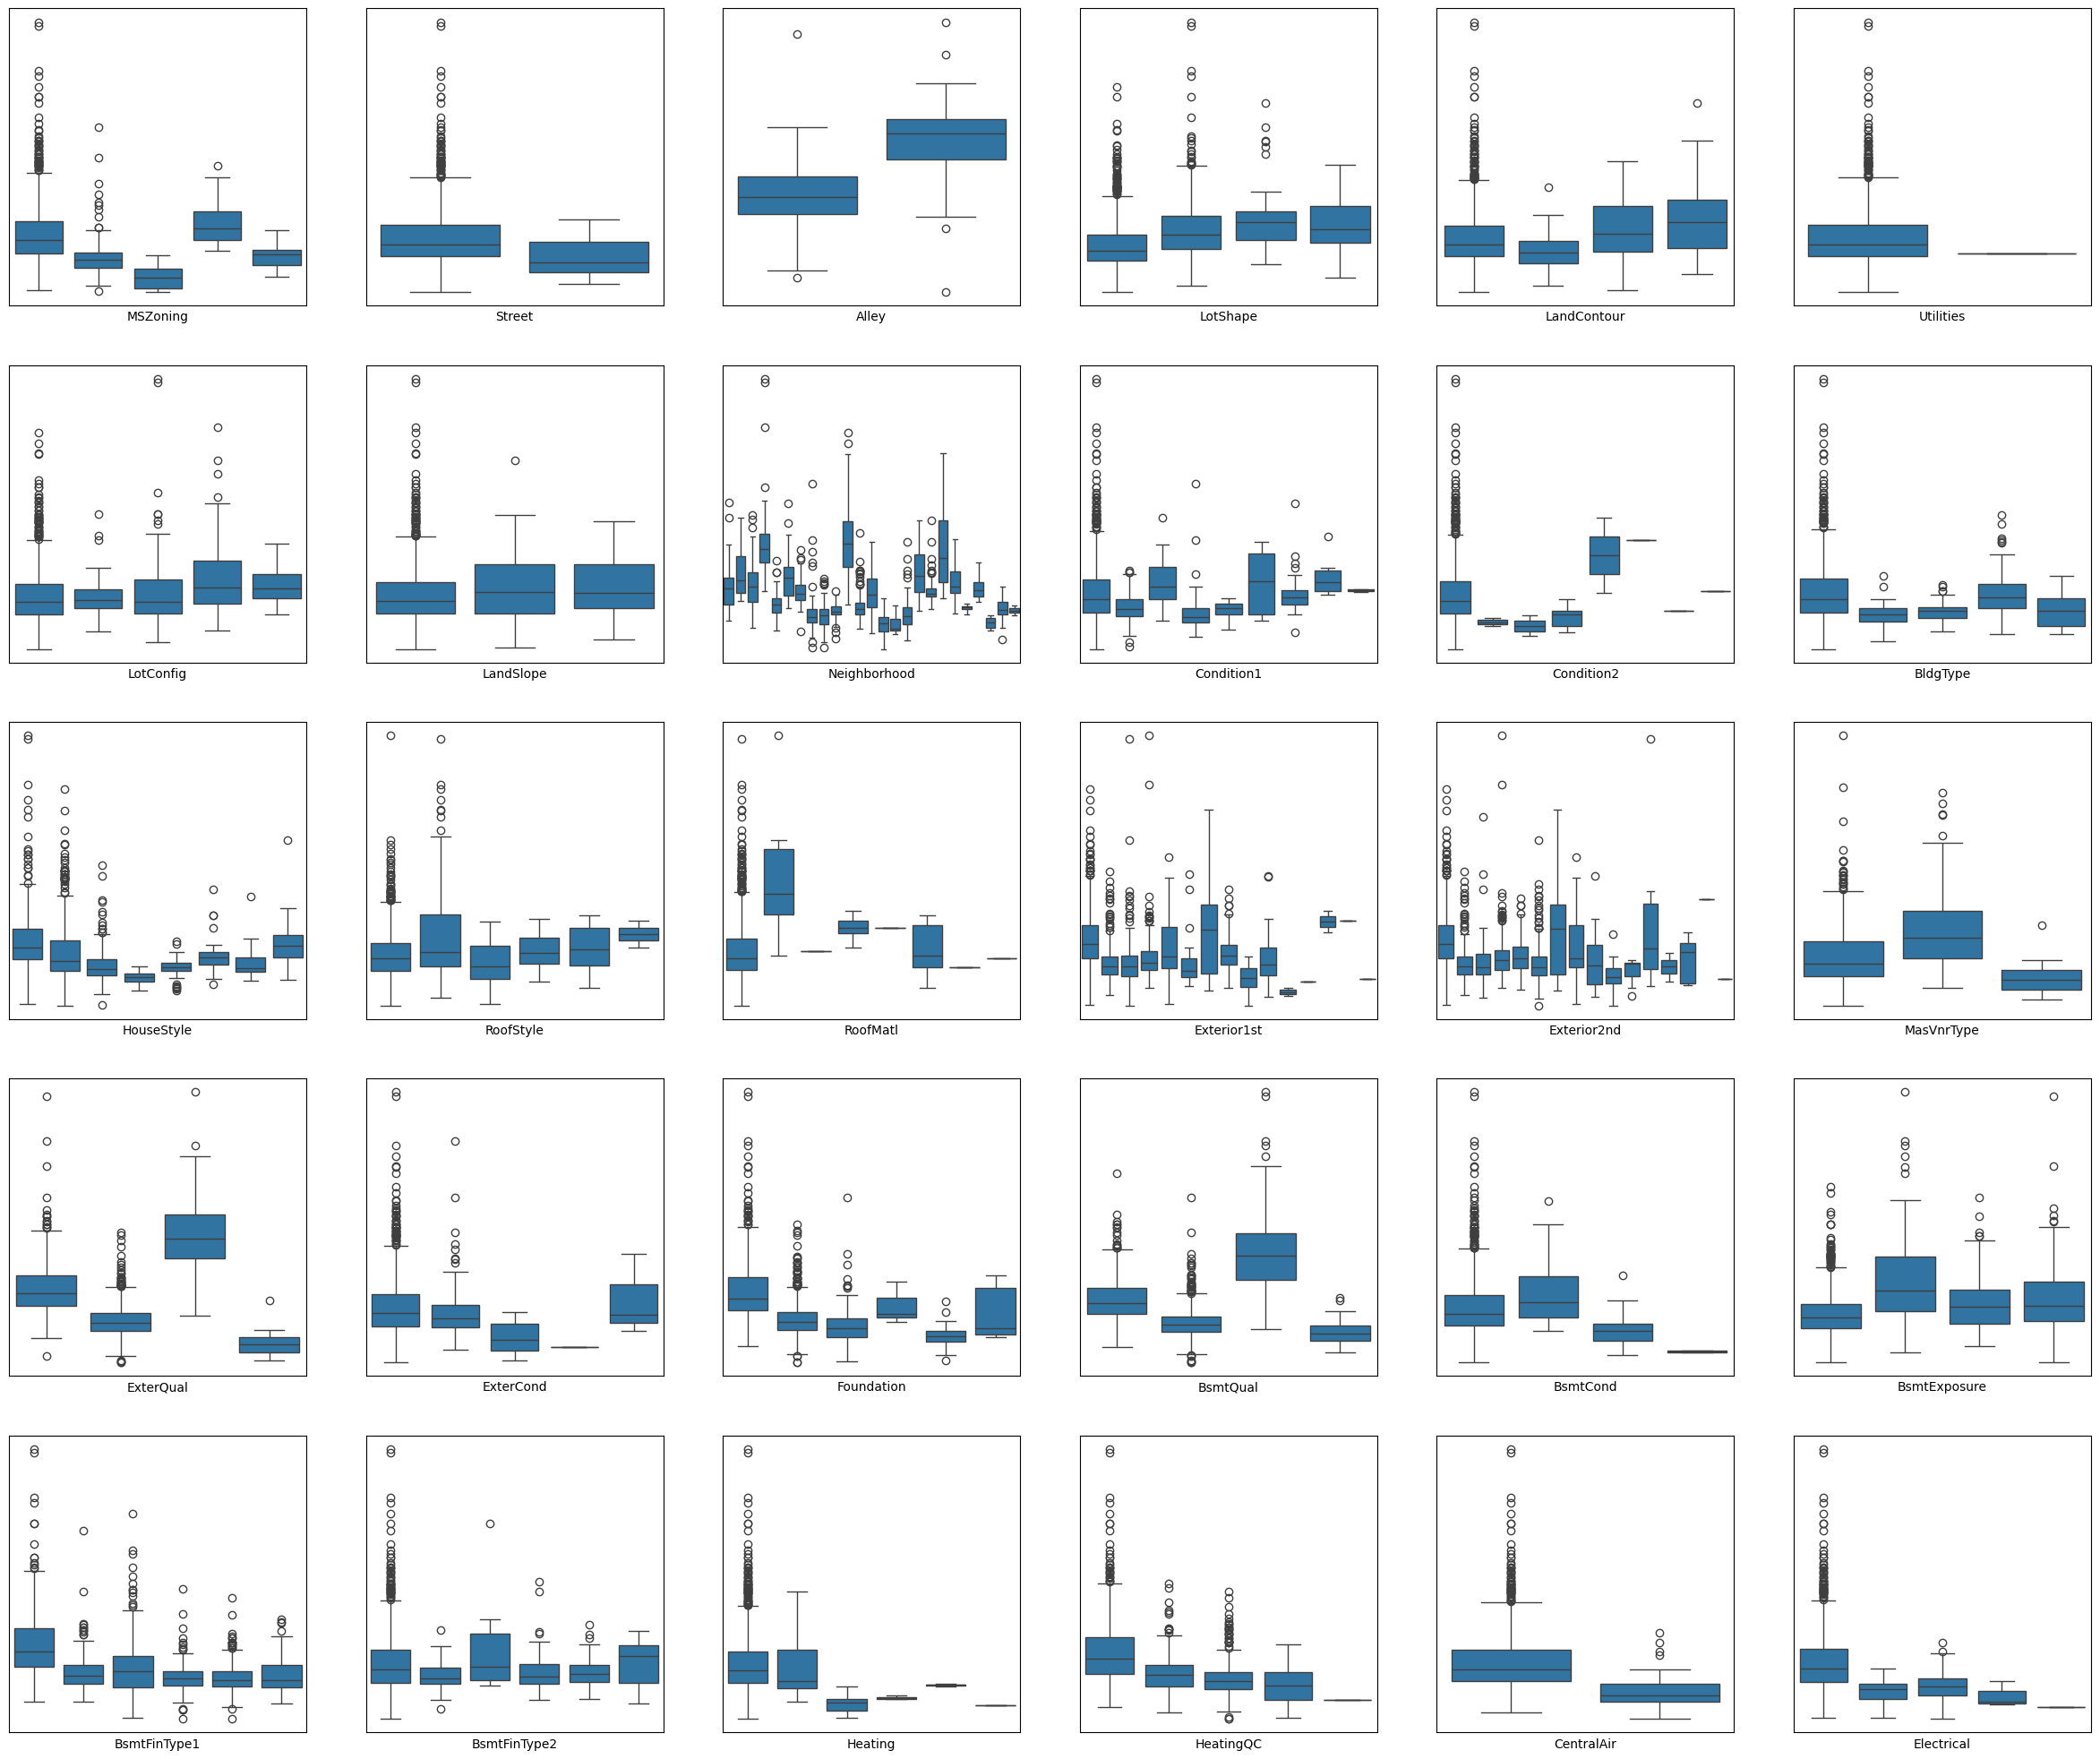

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, label='off', figsize=(30, 25))
n = 0

for i in range(5) :
  for j in range(6) :
    # Dtype(feature) = object
    sns.boxplot(x=object_cols[n], y='SalePrice', data=train, ax=axes[i, j])
    axes[i, j].set_ylabel('')
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    n += 1

- Oulier are watched regardless of Dtype. So, remove features if sample size is sufficient
- Object feature's which has low distribution class : Utilities, Condition2, RoofMatl, Exterior1st, Exterior2nd, ExterCond, BsmtCond, Heating, HeatingQC, Functional, MiscFeature

5. Numerical features Heatmap : analyze feature's Correlation

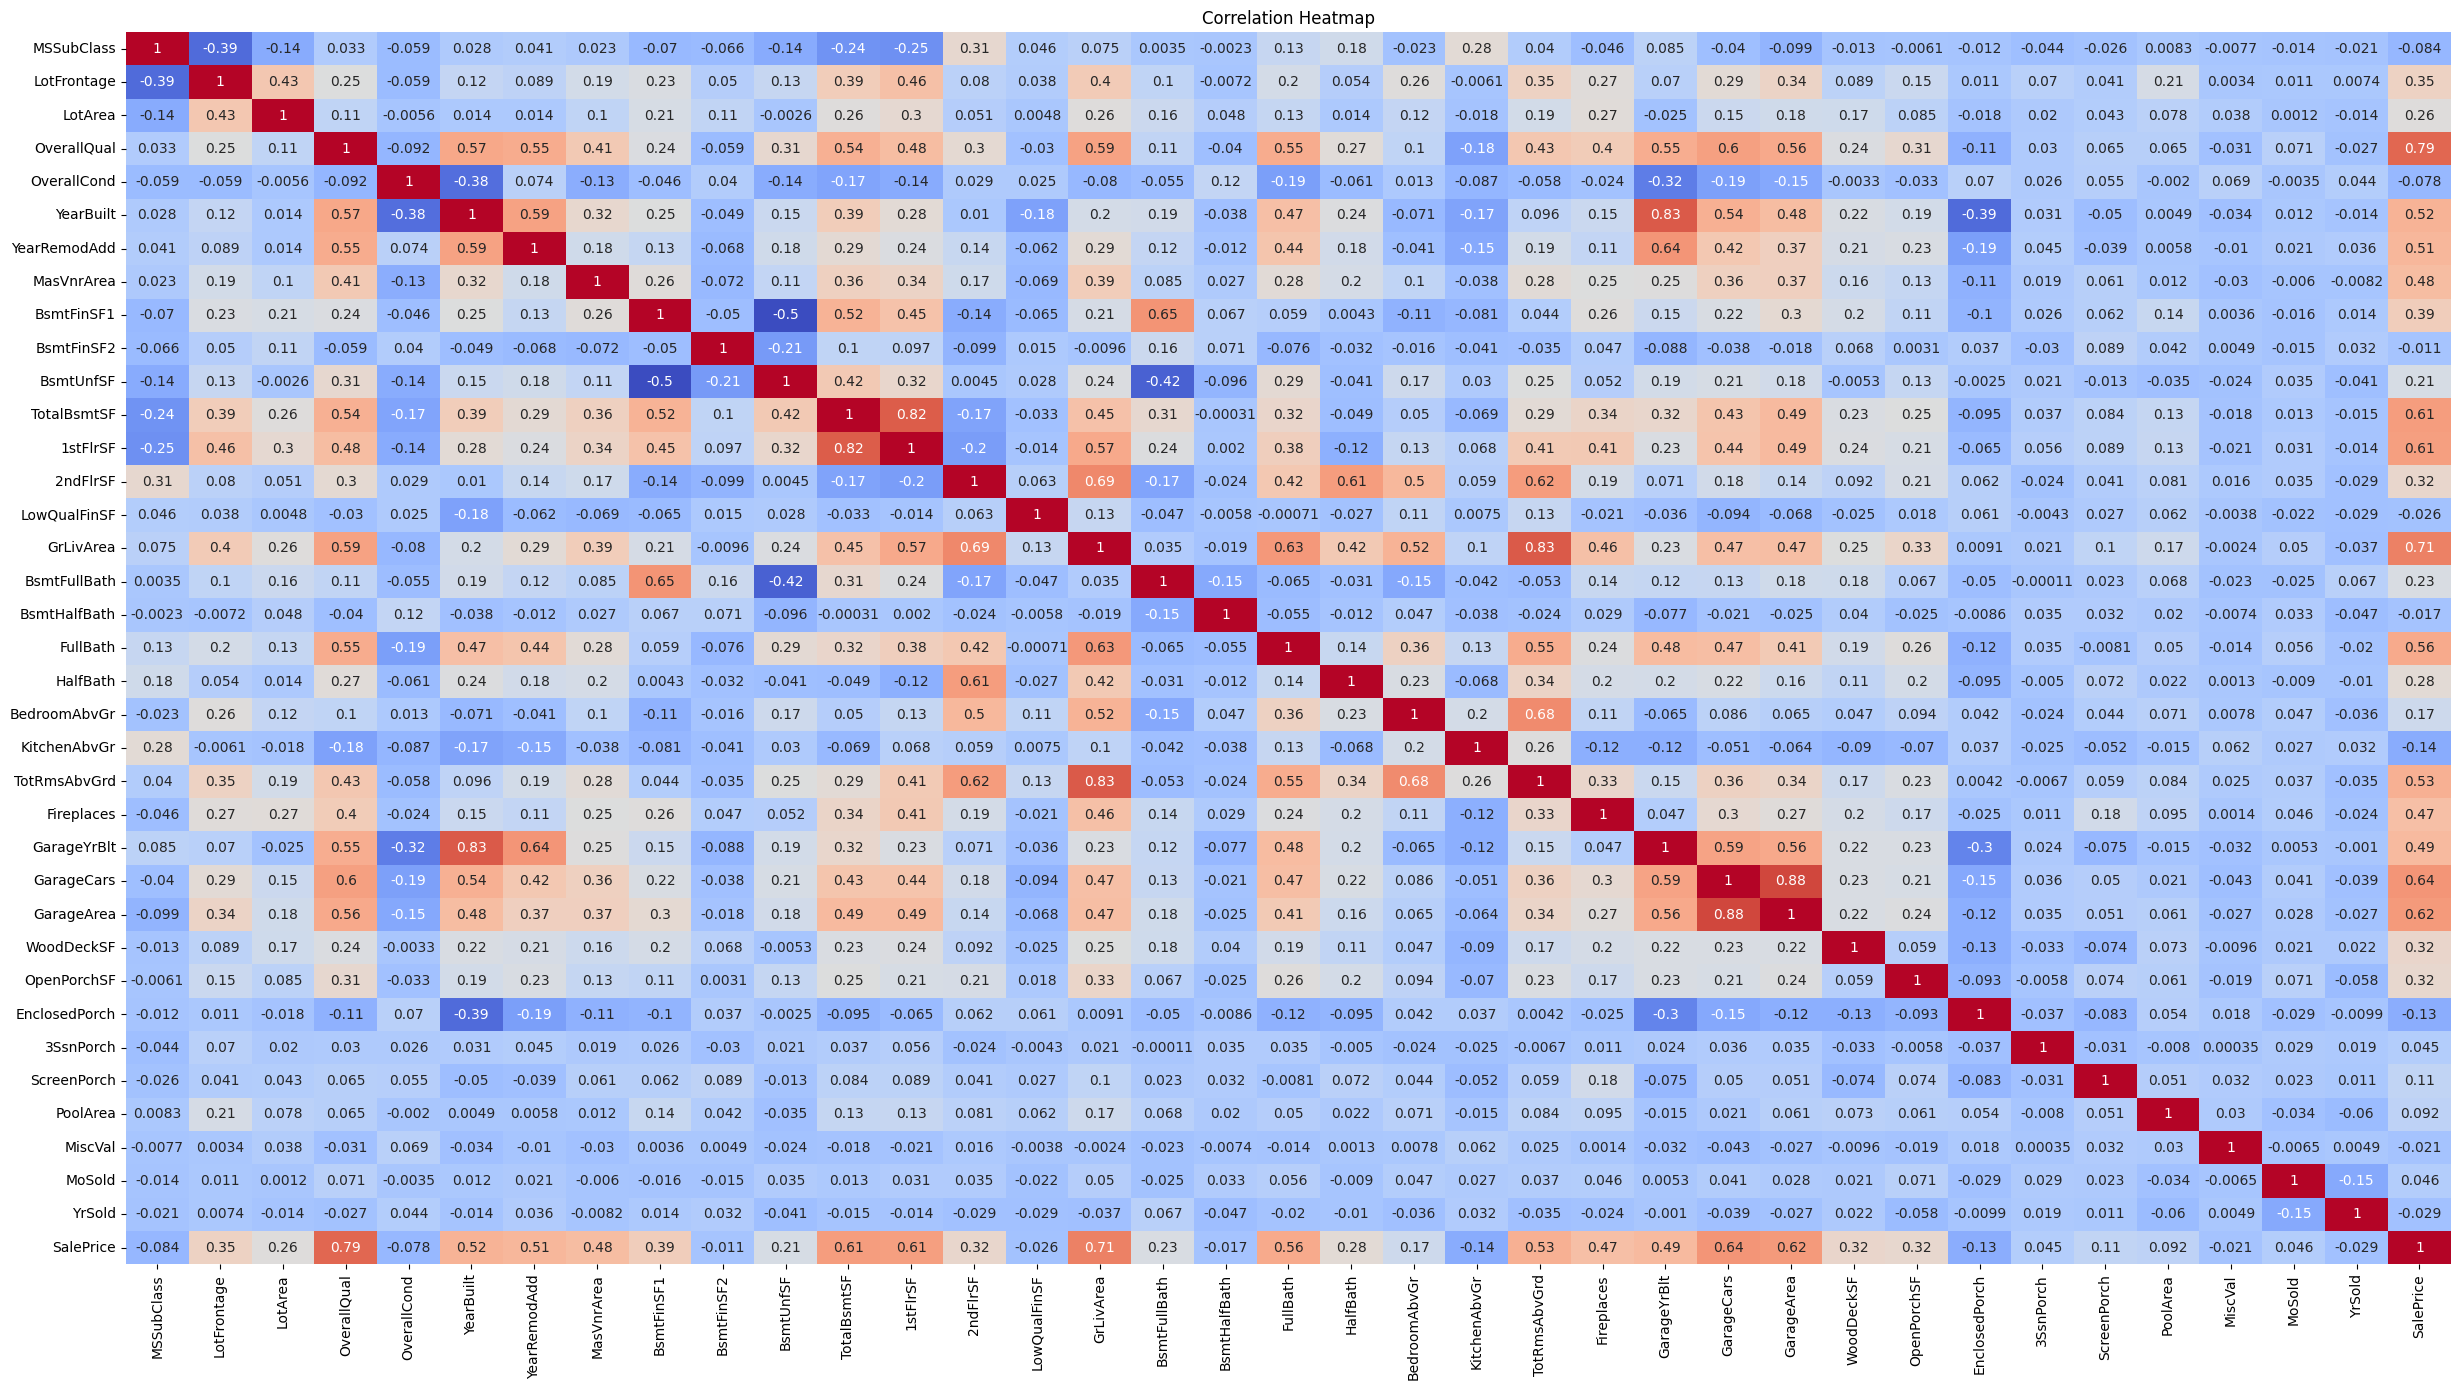

In [ ]:
numeric_df = train.select_dtypes(exclude=['object'])

# Create heatmap
plt.figure(figsize=(30, 16))
heatmap = sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation Heatmap')
plt.show()

Low Correlation features (with SalePrice) : Saved in low_corr_num_cols
- < 0.02 : BsmtFinSF2, BsmtHalfBath
- < 0.03 : LowQualFinSF, MiscVal, YrSold
- < 0.05 : 3SsnPorch, MoSold

# Evaluation : RMSE score

In [14]:
def RMSE_score(y_pred, y_test) : # model, real
  return np.sqrt(mean_squared_error(y_pred, y_test))

# Model Baseline

**1. Merge train, test dataset for feature unity, and remove Index(Id)**

In [15]:
merged_df = pd.concat([train, test])
merged_df = merged_df.drop(['Id'], axis=1)

**2. Remove Class columns which Na ratio is bigger than 0.4 (2-2)**

In [16]:
na_columns

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [17]:
merged_df = merged_df.drop(na_columns, axis=1)

**3. Remove numeric features which has low correlation (3-5)**

In [18]:
merged_df = merged_df.drop(low_corr_num_cols, axis=1)

**3. Creat remove_outlier function**
- Input : data(df), columns
- It works when 'sample > 100'
1) Calculate IQR using quantile
2) Check if 'sample size > 100' in that class
3) if True : remove that class in df
- return : df without meaningful outlier values

In [19]:
def remove_outlier(df, target) : # target : 'SalePrice'
  object_cols = df.select_dtypes(include=['object']).columns.tolist()

  for col in object_cols :
    # Create list checking values in feature
    name_list = df[col].unique().tolist()

    for name in name_list :
      Q1, Q2, Q3 = df[df[col] == name][target].quantile([0.25, 0.5, 0.75])
      IQR = Q3 - Q1 # Calculate IQR

      # Set outlier boundary
      min_value = Q1 - 1.5*IQR
      max_value = Q3 + 1.5*IQR

    # Check if 'sample size > 100' in the class
    for i, n in enumerate(df[col].value_counts()) :
      if n > 100 :
        subtract_df = df.loc[(df[col] == i) & ((min_value > df[target]) | (df[target] > max_value))]
        df.drop(subtract_df, axis=1)
  return df

In [20]:
merged_df = remove_outlier(merged_df, 'SalePrice') # Sample_size = 2919

**4. Divide merged_df into train and test for Target encoding**
- Target encoding only works when 'target value' exist

In [21]:
train = merged_df[~pd.isnull(merged_df['SalePrice'])]
test = merged_df[pd.isnull(merged_df['SalePrice'])]

X_train, y_train = train.drop(['SalePrice'], axis=1), train['SalePrice']
X_test = test.drop(['SalePrice'], axis=1)

In [22]:
object_cols = train.select_dtypes(include=['object']).columns.tolist()
num_cols = train.select_dtypes(exclude=['object']).columns.tolist()

# Target Encoding : Convert object features into numerical features.


**1. Target encoding for train data**

In [23]:
target_encoder = ce.TargetEncoder()
X_trans = target_encoder.fit_transform(X_train, y_train, random_state=42) # encoded_data

In [24]:
X_trans.shape, y_train.shape

((1460, 66), (1460,))

P) It doesn't use co-relation because feature's weight is normalized to 1

- 'LotFrontage', 'MasVnrArea' : Area(size), NaN might be '0(zero)'
- 'GarageYrBlt'(Year garage was built) : Corr=0.5인, 매우 중요한 feature..
- There are some useful ways for substituion(Na > ??), but this time, i dropped them

Merge DataFrame : Unity dropped features

In [25]:
y_train = pd.DataFrame(y_train)
X_trans['SalePrice'] = y_train

In [26]:
for col in X_trans.columns.tolist() :
  if X_trans[col].isna().any() :
    print(col) # Check if column has NaN value

LotFrontage

MasVnrArea

GarageYrBlt


In [27]:
X_trans['LotFrontage'] = X_trans['LotFrontage'].fillna(0)
X_trans['MasVnrArea'] = X_trans['MasVnrArea'].fillna(0)

In [28]:
X_trans.dropna(subset=['GarageYrBlt'], inplace=True)

In [29]:
# NaN이 존재하는지 다시 확인
for col in X_trans.columns.tolist() :
  if X_trans[col].isna().any() : print(col) # There is no NaN value

In [30]:
y_train, X_train = X_trans['SalePrice'], X_trans.drop(['SalePrice'], axis=1)

- P) Target encoding only works when target('SalePrice') exist
- S) ...

# Fit to the model

**1. Divide meged_data into train, test : test[target] is NaN**

In [31]:
X_train, X_test = X_trans[~pd.isnull(X_trans['SalePrice'])], X_trans[pd.isnull(X_trans['SalePrice'])]
y_train, y_test = X_trans[~pd.isnull(X_trans['SalePrice'])]['SalePrice'], X_trans[pd.isnull(X_trans['SalePrice'])]['SalePrice']

In [32]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1379, 67), (0, 67), (1379,), (0,))

**2. Linear Regression Model**

In [33]:
lin_model = LinearRegression()

In [73]:
lin_model_01 = lin_model.fit(X_train, np.log(y_train)) # Normal distribution에 가까워야 model 성능 좋으므로, log연산

In [74]:
RMSE_score(lin_model_01.predict(X_train), np.log(y_train))

0.07635574410395224

What should i do next?
- Check if RMSE score is better after feature scaling
- Target encoding should be applied in test dataset
- Check Target encoded feature's co-relation with target

# Re-model linear regression model using target-encodded feature

**1. Create Object_df**

In [36]:
object_df = X_train.loc[:, object_cols]
object_df['SalePrice'] = y_train

**2. Check co-relation (object_df & target)**

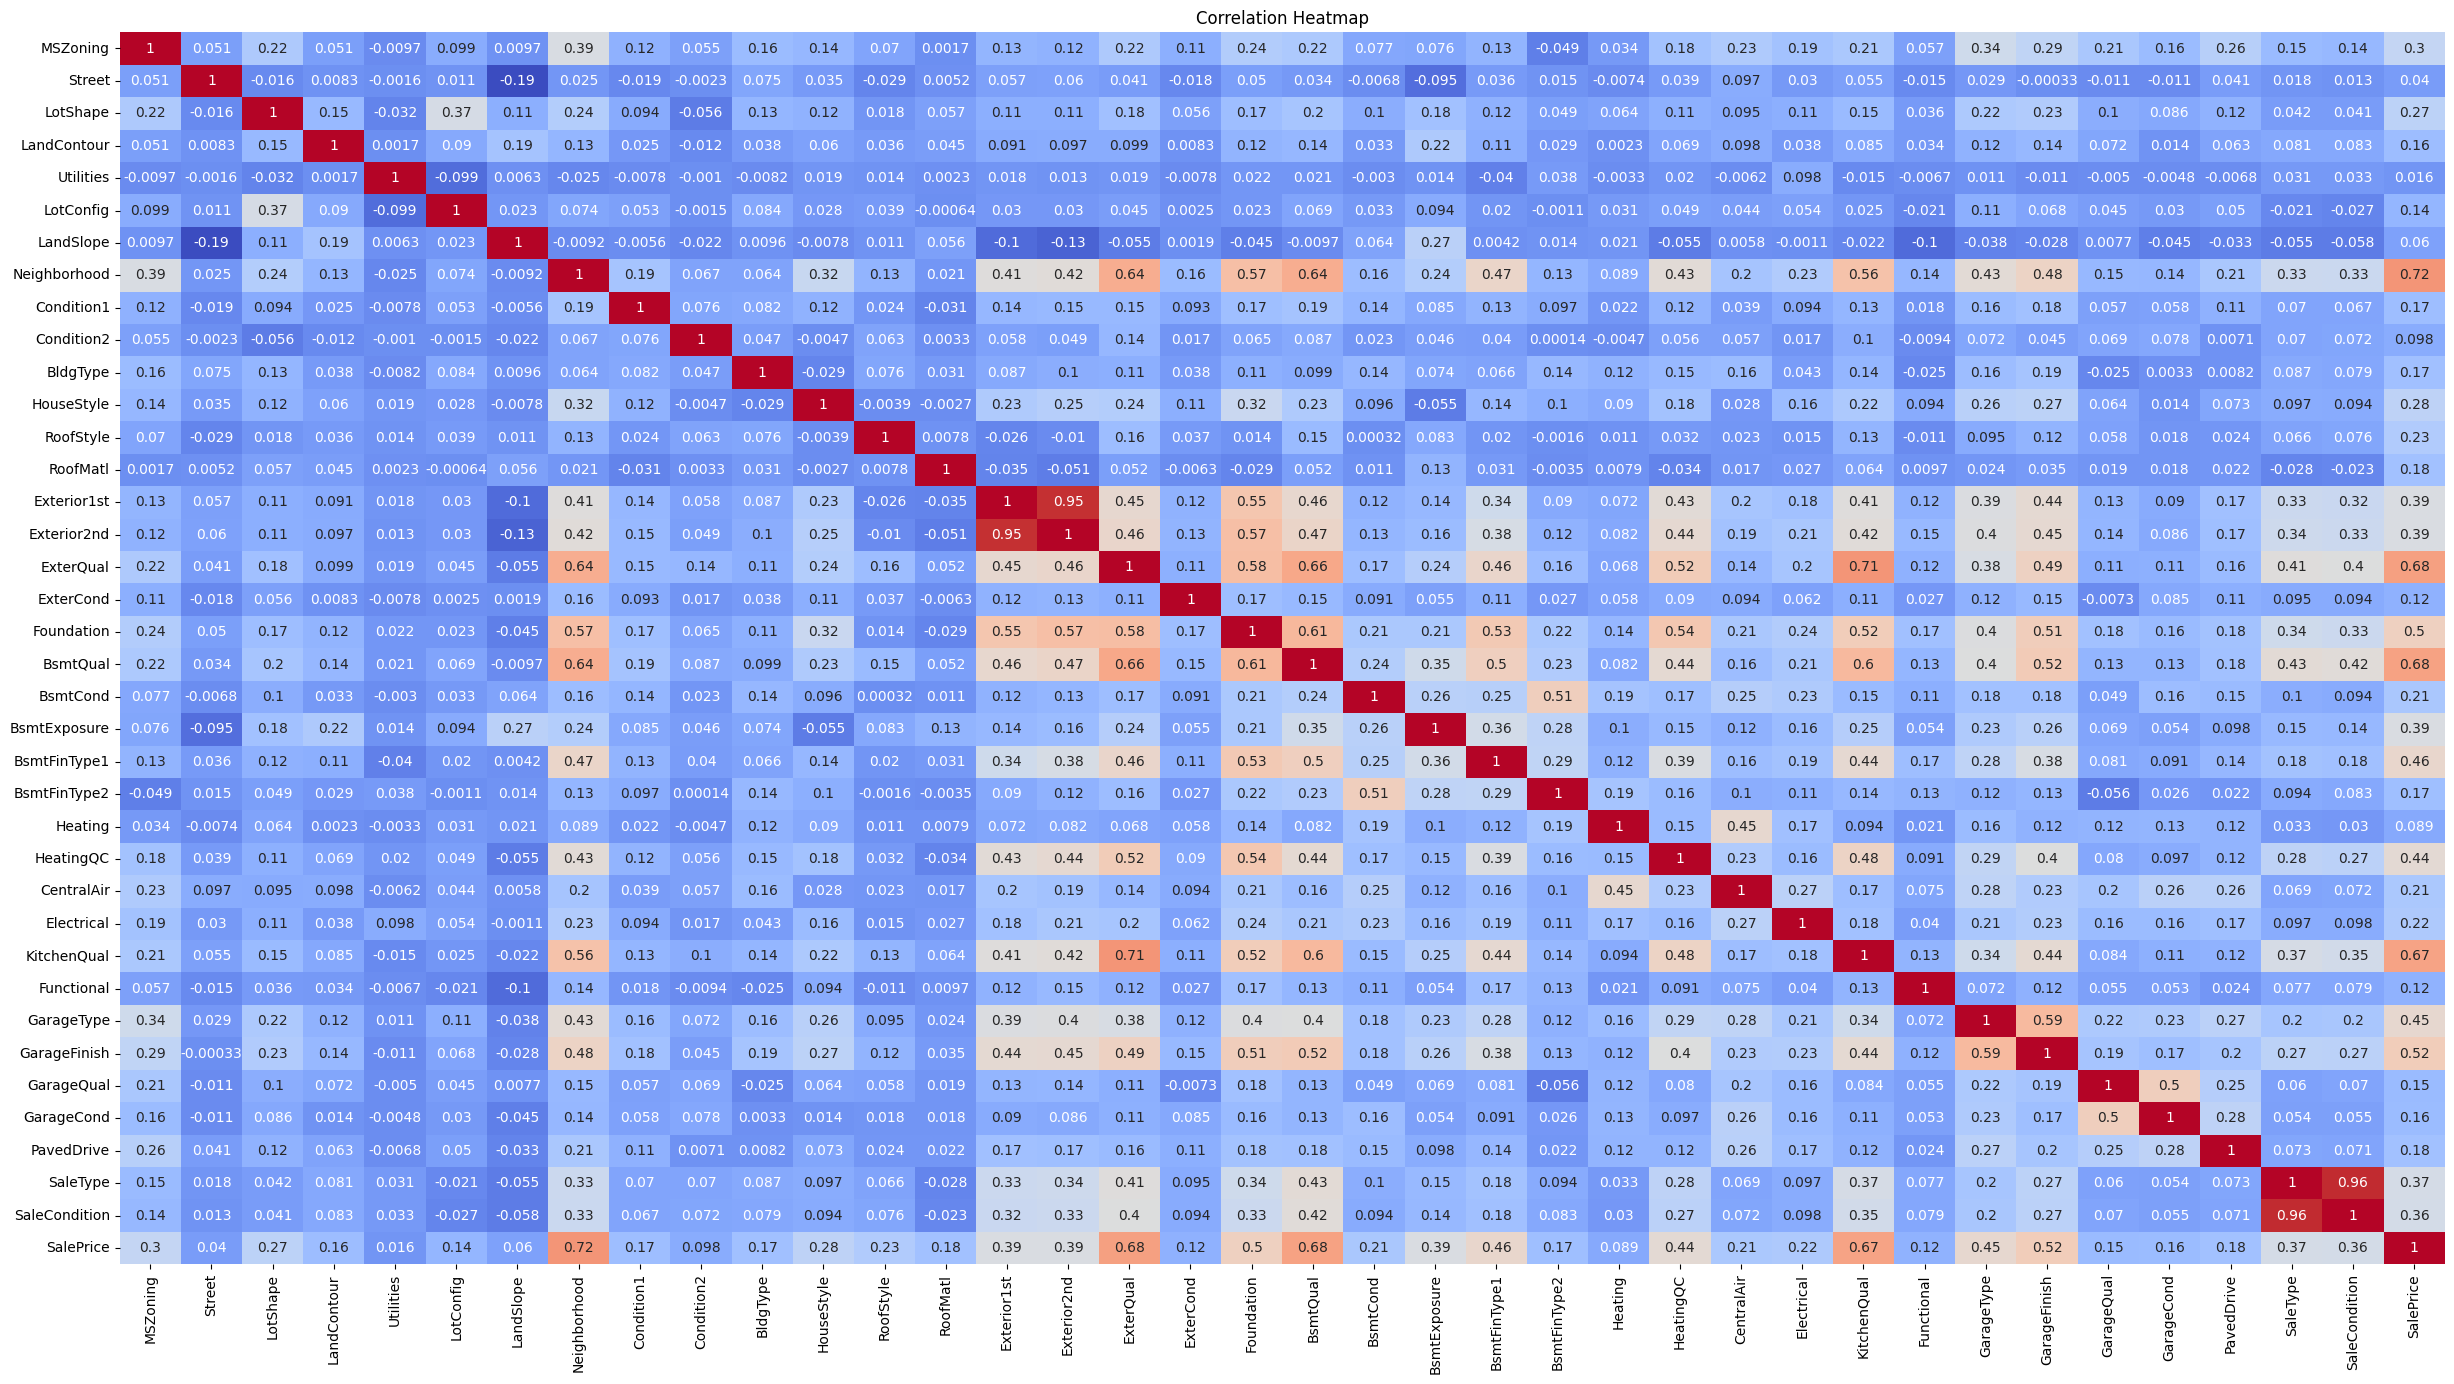

In [37]:
# Create heatmap 
plt.figure(figsize=(30, 16))
heatmap = sns.heatmap(object_df.corr(), annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation Heatmap')
plt.show()

In [38]:
# Corr : Object features & target('SalePrice')
# Extract features which abs(co-relation value) is lower than 0.05
low_corr_object_cols = []

for i, n in enumerate(X_train[object_cols].corr().iloc[:, -1]) :
  if abs(n) < 0.04 :
    print(object_cols[i], n)
    low_corr_object_cols.append(object_cols[i])

Street 0.013270679789373152

Utilities 0.03270919181118677

LotConfig -0.027495681493849275

RoofMatl -0.023212847576505984

Heating 0.02955158434555955


In [39]:
X_train_02 = X_train.drop(low_corr_object_cols, axis=1)

In [40]:
lin_model.fit(X_train_02, np.log(y_train))

LinearRegression()

In [41]:
RMSE_score(lin_model.predict(X_train_02), np.log(y_train))

0.07711384598874887

# Regularization

1. Regularization modifying alpha between 0.1 and 9.9

In [128]:
alpha_list = [float(i/10) for i in range(1, 100)] # 0.1 ~ 9.9

In [130]:
RMSE_ridge, RMSE_lasso, RMSE_elastic = [], [], []

for num in alpha_list :
  # Set Regularization model
  ridge = Ridge(alpha=num).fit(X_train, y_train)
  lasso = Lasso(alpha=num).fit(X_train, y_train)
  elastic = ElasticNet(alpha=num).fit(X_train, y_train)

  y_pred_ridge = ridge.predict(X_train)
  y_pred_lasso = lasso.predict(X_train)
  y_pred_elastic = elastic.predict(X_train)

  lin_model_ridge = lin_model.fit(X_train, np.log(y_pred_ridge))
  lin_model_lasso = lin_model.fit(X_train, np.log(y_pred_lasso))
  lin_model_elastic = lin_model.fit(X_train, np.log(y_pred_elastic))

  RMSE_ridge.append(RMSE_score(linear_model.predict(X_train), np.log(y_pred_ridge)))
  RMSE_lasso.append(RMSE_score(linear_model.predict(X_train), np.log(y_pred_lasso)))
  RMSE_elastic.append(RMSE_score(linear_model.predict(X_train), np.log(y_pred_elastic)))

In [135]:
min(RMSE_ridge), RMSE_ridge.index(min(RMSE_ridge))

(0.07635574414639615, 98)

In [139]:
min(RMSE_lasso), RMSE_lasso.index(min(RMSE_lasso))

(0.07635572777914235, 0)

In [141]:
min(RMSE_elastic), RMSE_elastic.index(min(RMSE_elastic))

(0.07635572444568776, 0)

2. Lasso, ElasticNet could have best model when alpha is lower than 0.1

In [153]:
alpha_list = [float(i/200) for i in range(1, 10)] # 0.01 ~ 0.09
alpha_list

[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045]

In [154]:
RMSE_lasso, RMSE_elastic = [], []

for num in alpha_list :
  # Set Regularization model
  lasso = Lasso(alpha=num).fit(X_train, y_train)
  elastic = ElasticNet(alpha=num).fit(X_train, y_train)

  y_pred_lasso = lasso.predict(X_train)
  y_pred_elastic = elastic.predict(X_train)

  lin_model_lasso = lin_model.fit(X_train, np.log(y_pred_lasso))
  lin_model_elastic = lin_model.fit(X_train, np.log(y_pred_elastic))

  RMSE_ridge.append(RMSE_score(linear_model.predict(X_train), np.log(y_pred_ridge)))
  RMSE_lasso.append(RMSE_score(linear_model.predict(X_train), np.log(y_pred_lasso)))
  RMSE_elastic.append(RMSE_score(linear_model.predict(X_train), np.log(y_pred_elastic)))

In [155]:
min(RMSE_lasso), RMSE_lasso.index(min(RMSE_lasso))

(0.0763557224316863, 3)

In [156]:
min(RMSE_elastic), RMSE_elastic.index(min(RMSE_elastic)) # best model

(0.07635572239366556, 7)

In [158]:
# Befor regularization - ElasticNet
0.07635574410395224 - 0.07635572239366556

2.1710286679521573e-08

결과적으로, '2.1710286679521573e-08' 만큼의 개선이 이루어짐

# Optional task : Apply target encoding into test dataset

**1. Extract unique value from dataset's object_cols**

In [ ]:
object_data = []

for col in object_cols :
  object_data.append([train[col].unique(), X_train[col].unique()])

object_data[0]

[array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object),
 array([191004.99478714, 126316.8304127 , 152307.65856355, 213650.4721221 ,
        161111.28673543])]

**2. test에서 object_value를 embedded_value로 교체하기**

**3. test에 model을 적용해 csv 생성하기**